# Космический корабль Титаник

---


#### Random Forest

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore')

In [1]:
def check_missing_values(df):

    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Обнаружены пропущенные значения:")
        print(missing_values[missing_values > 0])
        return True
    else:
        print("Пропущенные значения не обнаружены.")
        return False

In [2]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [4]:
def plot_roc_curve(y_true, y_proba, model_name="Model"):
    """Строит и отображает ROC-кривую."""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def random_forest_pipeline_with_imputation(train_data, target_column, imputation_strategy='median', knn_neighbors=5, random_state=42):  # Изменено значение по умолчанию для strategy на 'median'

    X = train_data.drop(target_column, axis=1)
    y = train_data[target_column].astype(int)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

    numerical_features = X_train.select_dtypes(include=['number']).columns
    categorical_features = X_train.select_dtypes(exclude=['number']).columns

    if imputation_strategy == 'mean' or imputation_strategy == 'median':
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy=imputation_strategy)),
            ('scaler', StandardScaler())
        ])
    elif imputation_strategy == 'knn':
        if len(numerical_features) == 0:
            imputation_strategy = 'median'
            print("Warning: No numerical features for KNN imputation. Switching to median imputation.")
            numerical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy=imputation_strategy)),
                ('scaler', StandardScaler())
            ])
        else:
            numerical_transformer = Pipeline(steps=[
                ('imputer', KNNImputer(n_neighbors=knn_neighbors)),
                ('scaler', StandardScaler())
            ])
    else:
        raise ValueError("Invalid imputation strategy. Must be 'mean', 'median', or 'knn'.")

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=random_state))])
    param_grid = {
        'classifier__n_estimators': [50, 100, 200], # Количество деревьев
        'classifier__max_depth': [None, 10, 20],  # Максимальная глубина дерева
        'classifier__min_samples_split': [2, 5, 10], # Минимальное количество выборок для разделения узла
        'classifier__min_samples_leaf': [1, 2, 4]    # Минимальное количество выборок в листовом узле
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

    X_train_processed = preprocessor.fit_transform(X_train)
    if np.isnan(X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed).any():
        raise ValueError("NaN values present in X_train_processed after preprocessing.")

    try:
        grid_search.fit(X_train, y_train)
    except Exception as e:
        print(f"Error during GridSearchCV fitting: {e}")
        return None, None

    return grid_search.best_estimator_, grid_search.best_params_

Проверка пропущенных значений в обучающих данных:
Обнаружены пропущенные значения:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64

Проверка пропущенных значений в тестовых данных:
Обнаружены пропущенные значения:
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

Training with imputation strategy: mean
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Training with imputation strategy: median
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Training with imputation strategy: knn
Fitting 3 folds for each of 81 candidates, totalling 243 fits

----- Top 3 Model

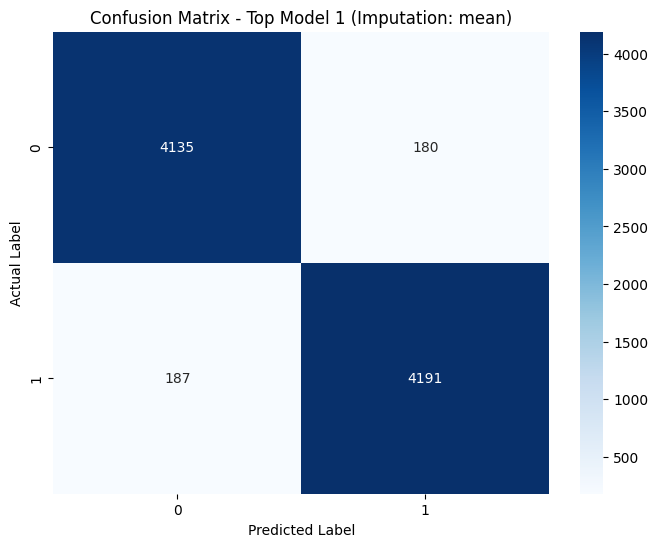

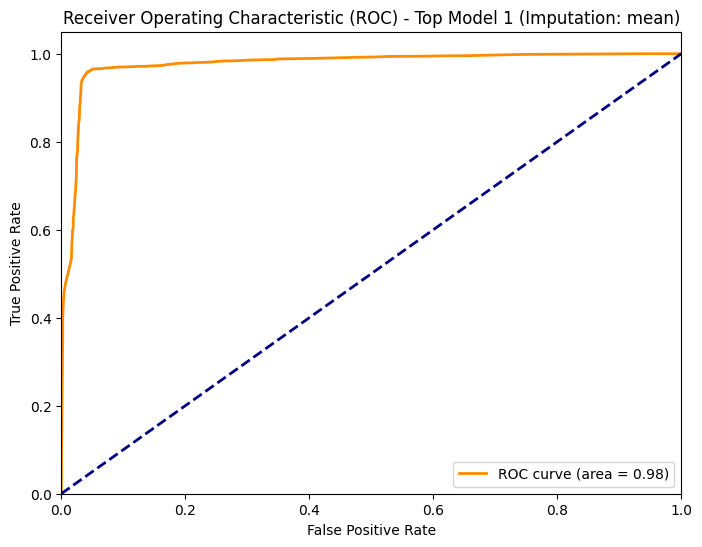


----- Model 2 -----
Imputation Strategy: knn
Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Accuracy: 0.7837837837837838
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       861
           1       0.79      0.77      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

Confusion Matrix:
[[686 175]
 [201 677]]


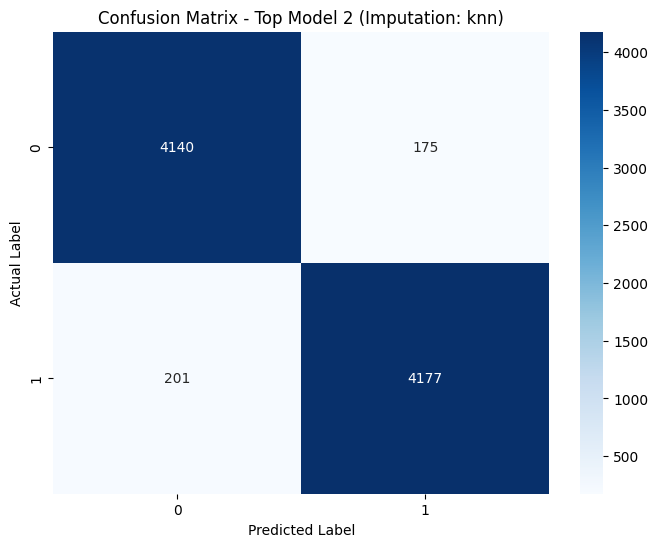

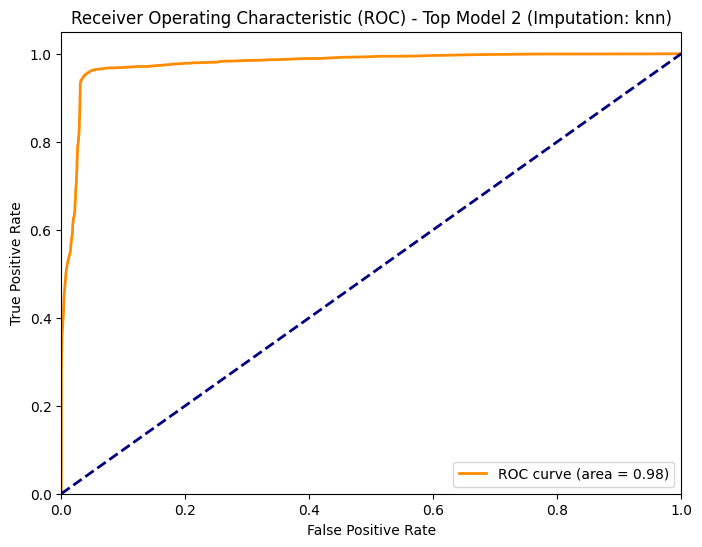


----- Model 3 -----
Imputation Strategy: median
Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Accuracy: 0.7814836112708453
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       861
           1       0.79      0.77      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

Confusion Matrix:
[[683 178]
 [202 676]]


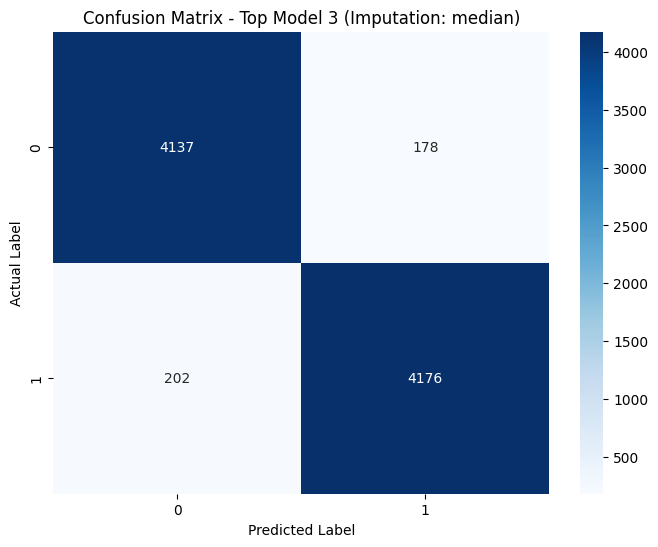

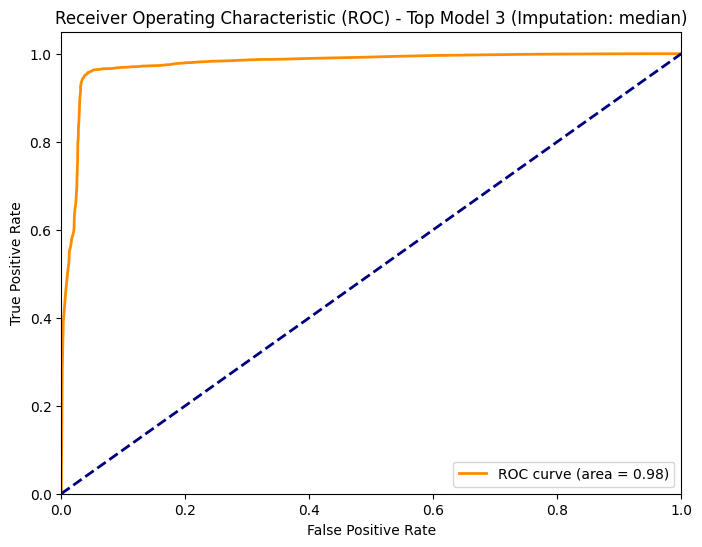

In [6]:
if __name__ == '__main__':

    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    train_data['Transported'] = train_data['Transported'].astype(str).map({'True': 1, 'False': 0})
    target_column = 'Transported'

    print("Проверка пропущенных значений в обучающих данных:")
    has_missing_train = check_missing_values(train_data)
    print("\nПроверка пропущенных значений в тестовых данных:")
    has_missing_test = check_missing_values(test_data)

    imputation_strategies = ['mean', 'median', 'knn']
    all_models = []

    for imputation_strategy in imputation_strategies:
        print(f"\nTraining with imputation strategy: {imputation_strategy}")
        pipeline, params = random_forest_pipeline_with_imputation(
            train_data.copy(), target_column, imputation_strategy=imputation_strategy
        )

        if pipeline is not None:
            all_models.append((pipeline, imputation_strategy, params))
        else:
            print(f"Skipping imputation strategy {imputation_strategy} due to training error.")

    X = train_data.drop(target_column, axis=1)
    y = train_data[target_column].astype(int)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model_evaluations = []
    for pipeline, strategy, params in all_models:
        y_pred = pipeline.predict(X_val)
        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
        accuracy = accuracy_score(y_val, y_pred)
        classification_report_str = classification_report(y_val, y_pred)
        confusion_matrix_result = confusion_matrix(y_val, y_pred)

        model_evaluations.append((pipeline, strategy, params, accuracy, classification_report_str, confusion_matrix_result))

    model_evaluations = sorted(model_evaluations, key=lambda x: x[3], reverse=True)

    top_n = min(5, len(model_evaluations))
    print(f"\n----- Top {top_n} Models -----")
    for i in range(top_n):
        pipeline, strategy, params, accuracy, classification_report_str, confusion_matrix_result = model_evaluations[i]
        print(f"\n----- Model {i+1} -----")
        print(f"Imputation Strategy: {strategy}")
        print(f"Parameters: {params}")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{classification_report_str}")
        print(f"Confusion Matrix:\n{confusion_matrix_result}")

        y_pred = pipeline.predict(train_data.drop(target_column, axis=1))
        y_pred_proba = pipeline.predict_proba(train_data.drop(target_column, axis=1))[:, 1]

        plot_confusion_matrix(train_data[target_column], y_pred, model_name=f"Top Model {i+1} (Imputation: {strategy})")
        plot_roc_curve(train_data[target_column], y_pred_proba, model_name=f"Top Model {i+1} (Imputation: {strategy})")